# Quick Comparison CNOGpro, CNVnator, sequana_coverage for the detection of CNVs (bacteria case)

From CNOGpro paper (see link below), there use 6 different sets of FastQ files available on ENA from staphylococcus.

They found 37, 37, 25, 27, 27, 26 events in the 6 differents data sets

https://academic.oup.com/bioinformatics/article/31/11/1708/2365681

as shown in the supplementary SD1.

In [5]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [8, 6]

Populating the interactive namespace from numpy and matplotlib


You can download the data from EBI and the reference using sequana_coverage or your 
favorite tool:

In [ ]:

!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR043/ERR043375/ERR043375_1.fastq.gz
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR043/ERR043375/ERR043375_2.fastq.gz
!sequana_coverage --download-reference FN433596    


In [2]:
# Perform the mapping

In [ ]:
!sequana_mapping --file1 ERR043375_1.fastq.gz --file2 ERR043375_2.fastq.gz --reference FN433596.fa 
!mv FN433575.fa.sorted.bam ERR043375.bam
!bioconvert ERR043375.bam ERR043375.bed -f

Same for accession numbers:

- ERR316404
- ERR142616
- ERR043379
- ERR043367
- ERR043375
- ERR043371


In [10]:
!sequana_coverage -w 40001 -o --output-directory report_ERR043367 --input ERR043367.bed  1>out 2>err

In [11]:
!sequana_coverage -w 40001 -o --output-directory report_ERR043375 --input ERR043375.bed  1>out 2>err

In [12]:
!sequana_coverage -w 40001 -o --output-directory report_ERR043371 --input ERR043371.bed  1>out 2>err

In [13]:
!sequana_coverage -w 40001 -o  --output-directory report_ERR043379 --input ERR043379.bed 1>out 2>err

In [14]:
!sequana_coverage -w 40001 -o --output-directory report_ERR142616 --input ERR142616.bed  1>out 2>err

In [15]:
!sequana_coverage -w 40001 -o --output-directory report_ERR316404 --input ERR316404.bed  1>out 2>err

In [17]:
!cp report_ERR043371/*/*/rois.csv roi_ERR043371.csv
!cp report_ERR043375/*/*/rois.csv roi_ERR043375.csv
!cp report_ERR043367/*/*/rois.csv roi_ERR043367.csv
!cp report_ERR043379/*/*/rois.csv roi_ERR043379.csv
!cp report_ERR142616/*/*/rois.csv roi_ERR142616.csv
!cp report_ERR316404/*/*/rois.csv roi_ERR316404.csv

In [18]:
import pandas as pd

In [19]:
roi1 = pd.read_csv("roi_ERR043371.csv")
roi2 = pd.read_csv("roi_ERR043375.csv")
roi3 = pd.read_csv("roi_ERR043367.csv")
roi4 = pd.read_csv("roi_ERR043379.csv")   #the one used to plot a coverage signal 
roi5 = pd.read_csv("roi_ERR142616.csv")
roi6 = pd.read_csv("roi_ERR316404.csv")

In [25]:
%pylab inline
rcParams['figure.figsize'] = (10,8)

Populating the interactive namespace from numpy and matplotlib


In [26]:
# We divide the fifth case by 10 to show on the same scale more or less
def plot_rois(m1=85000, m2=90000, ymax=500):
    from sequana import GenomeCov
    b = GenomeCov("ERR043379.bed")
    chromosome = b.chr_list[0]
    N = len(chromosome.df)
    chromosome._df = chromosome.df.iloc[max(0,m1-40001): min(m2+40001, N)]
    chromosome.running_median(40001)
    chromosome.compute_zscore(k=2)
    
    #chromosome.df = chromosome.df.iloc[m1:m2]
    chromosome.plot_coverage()

    i = 1
    for roi, color in zip([roi1, roi2, roi3, roi4, roi5, roi6], ["r", "g", "y", "k", "m", "orange"]):
        for start, end, cov in zip(roi.start, roi.end, roi.mean_cov):
            if i == 5:
                plot([start, end], [cov/10., cov/10.], lw=2, color=color, marker="o")
            else:
                plot([start, end], [cov, cov], lw=2, color=color, marker="o")
        i+=1
        xlim([m1,m2])
        ylim([0,ymax])

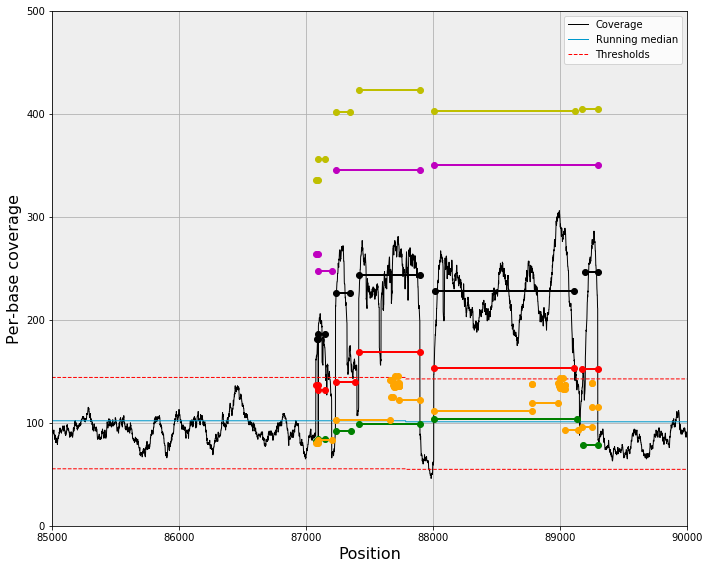

In [27]:
plot_rois(85000, 90000)

Here we focus on a quite complex pattern from position 87000 to 89500. The black line corresponds to the coverage of the strain ERR043379. The colored short horizontal lines correspond to the detected ROIs from sequana_coverage. The black horizontal lines correspond to the ROIs found in ERR043379. The other colored lines correspond to the 5 other strains, for which the coverage is not shown for simplicity. What we see is that the same events are detected in the 6 strains (that have different coverage). We see that there are 5-6 different events very close to each others.

The sequana_coverage code detects more events than CNOGpro but this could be events split into several sub-events so we will need more investigations and plotting tools  hereafter

### number of events detected by sequana_coverage.


In [29]:
len(roi1), len(roi2), len(roi3), len(roi4), len(roi5), len(roi6)

(79, 114, 77, 98, 114, 163)

# IS431-1 between 58553-59342 and IS432-2 at 66346-67135

The genomic region here above include the IS431-1 and IS431-2 (gray regions). This genomic region

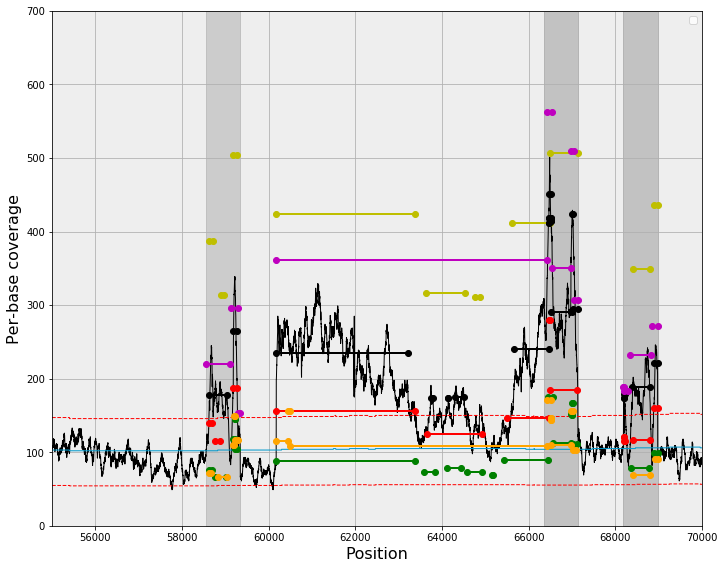

In [30]:
plot_rois(55000, 70000)
legend([])
ylim([0, 700])
fill_between([58553, 59342], 700, 0, color="gray", alpha=0.3)
fill_between([66346, 67135], 700, 0, color="gray", alpha=0.4)
fill_between([68188, 68977], 700, 0, color="gray", alpha=0.4)

# Copy number estimation

it could be interesting to estimate the copy number as reported in CNOGpro or CNVnator. Here is a simple tool to to so.
We extract the data between the starting and ending point reported by sequana_coverage. We use the mean coverage 
and running median (average) of the events. This will be our estimate. 

(1, 4)

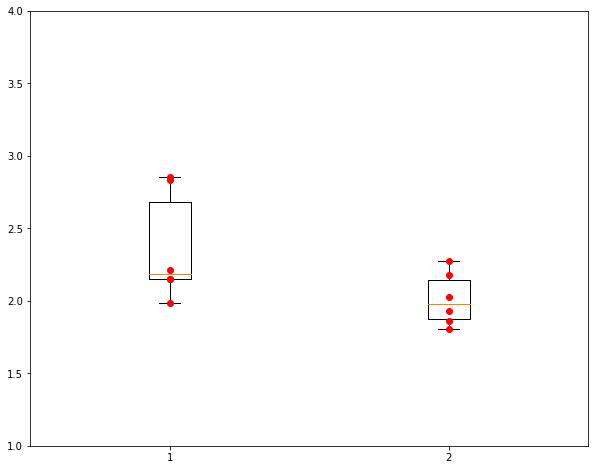

In [33]:
rois = [roi1, roi2 ,roi3, roi4, roi5, roi6]
CNs = []
def get_CN(m1,m2):
    CN = []
    for roi in rois:
        X = roi.query("start>@m1 and end<@m2");
        if len(X):
            CN.append((X['mean_cov'] / X['mean_rm']).mean())
    return CN

# Some evens shown above
CNs.append(get_CN(58000, 60000))
CNs.append(get_CN(68000, 70000))

_ = boxplot(CNs)
for i,CN in enumerate(CNs):
    plot([i+1]*6, CN, "or", ms=6)
ylim([1,4])    

# Another interesting event

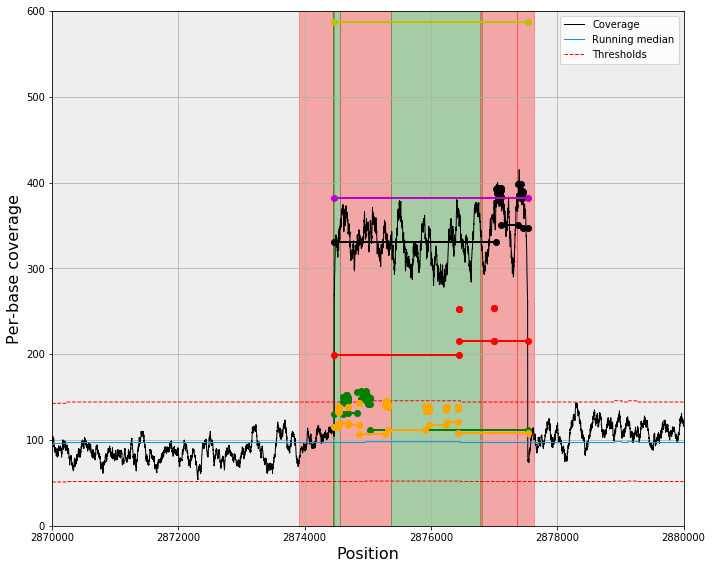

In [34]:
plot_rois(2870000,2880000,ymax=600)
# a duplication with CN = 3 of length 3064
ymax=600

# Here we plot the reported CNVs for ERR043379 isolate using CNOGpro as
# indicated in the supplmentary ST1
# Comments indicates the reported Copy Number in the refrence
# colors have no meaning: we alternate red and green to distinguish the 
# detected fragments
fill_between([2874445,2874468], ymax,0, color="g", alpha=0.3) # 2
fill_between([2873916,2874443], ymax,0, color="r", alpha=0.3) # 1,2
fill_between([2874444,2874552], ymax,0, color="g", alpha=0.3) # 1,2,3
fill_between([2874553,2875368], ymax,0, color="r", alpha=0.3) # 3
fill_between([2875361,2876803], ymax,0, color="g", alpha=0.3) # 3
fill_between([2876775,2877368], ymax,0, color="r", alpha=0.3) # 1,3,4 
fill_between([2877369,2877631], ymax,0, color="r", alpha=0.3) # 1 4

# Note that using sequana_coverage, we detect a single event (horizontal colored bars)
# Moreover, the boundary is correct in sequana coverage while CNOGpro boundary are 
# not as precise on this isolate example. Other isolates show the same type of behaviour.

# finally, our CN are equal to 3.3+-0.1 std whereas CN number from CNOGpro seems 
# to be more spread with value. In the paper they wrote that 
#
#     "in ERR043367 and ERR043371 the data indicated that tnpR resolvase might 
#      be present at a copy number of 4"
#
# that does not seem to be the case with sequana_coverage numbers (all are around 3.3)

In [35]:
# Let us keep track of the copy number of this event in the 6 strains
CNs.append(get_CN(2870000,2878000))


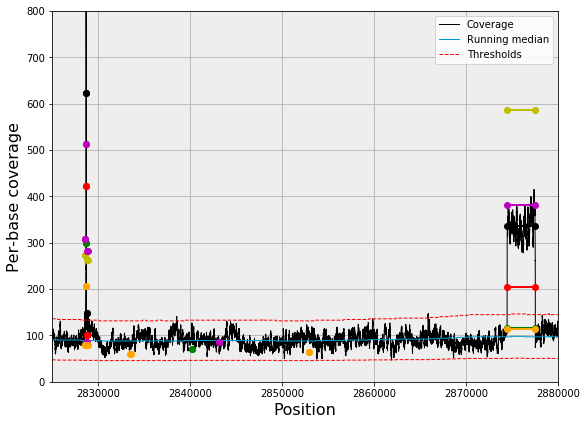

In [287]:
plot_rois(2825000,2880000, ymax=800)


(1, 7)

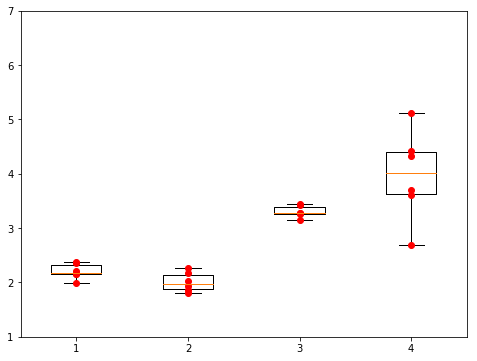

In [175]:
CNs.append(get_CN(2820000,2830000))

_ = boxplot(CNs)
for i,CN in enumerate(CNs):
    plot([i+1]*6, CN, "or", ms=6)
ylim([1,7])    

# Comparison CNVnator

```
module load cnvnator
cnvnator -root out1.root -tree ERR043371.bam 
cnvnator -root out1.root -his 100
cnvnator -root out1.root -stat 100
cnvnator -root out1.root -partition 100 -ngc
cnvnator -root out1.root -call 100 -ngc > events_bin100.txt
```

- with bin of 100, got 10 events, took 2 minutes
- **with bin of 20   got 17 events took 10 minutes**
- with bin of 10,  got 25 events, took 3 minutes
- with bin of 1,   got 75 events, took 30 minutes 

In [36]:
cnvnator = pd.read_csv("events_bin20.txt", header=None, sep="\s+")
events = cnvnator[1].apply(lambda x: [int(this) for this in x.split(":")[1].split("-")])


Note that as compared to CNOGpro or sequana_coverage, there are only a few detections

In [37]:
def plot_event(x1, x2):
    plot_rois(x1-5000, x2+5000)
    fill_between([x1,x2], y1=ylim()[1], alpha=0.3, color="g")

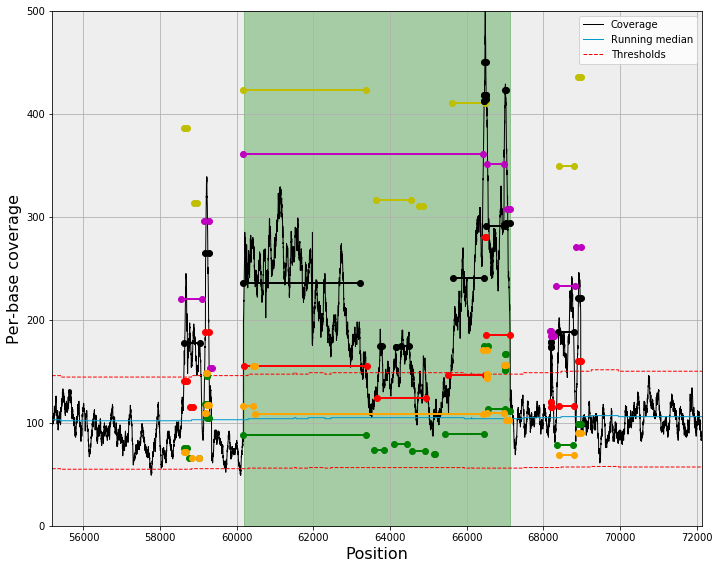

In [38]:
plot_event(*events[1])

0
1
2
3
4
5
6
7


WARNING [sequana]:  
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=0.9860940307442819, m1=1.089514941824108, sigma0=0.15948364299384746, sigma1=0.20234850328206855


8


WARNING [sequana]:  
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=0.9912715385397459, m1=1.0213378169697362, sigma0=0.12284541891333549, sigma1=0.1752208737184682


9
10
11
12
13
14


WARNING [sequana]:  
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=1.0023323358761804, m1=1.0390035609536372, sigma0=0.1668973927293892, sigma1=0.20775629059996037


15
16


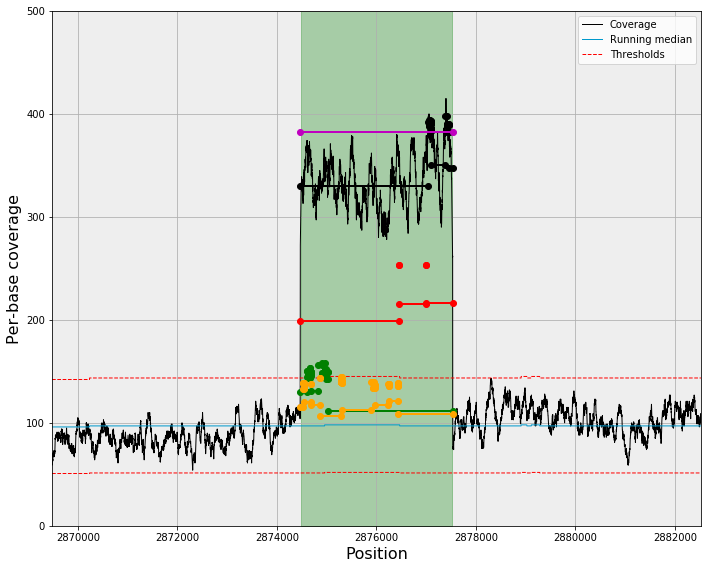

In [39]:
cnvnator = pd.read_csv("events_bin20.txt", header=None, sep="\s+")
events = cnvnator[1].apply(lambda x: [int(this) for this in x.split(":")[1].split("-")])

for i, event in enumerate(events):
    plot_event(*event)
    savefig("cnvnator_bin20_{}.png".format(i+1))
    print(i)


ERR043371: 
    - 37 CNVs detection in CNORGpro
    - 9 in CNVnator (bin 100)
    - 18 in CNVnator (bin 20)
    - 

# False event in CNVnator ? 
amongst  the 17 events detected, some are false alarms like this events 
that is not detected in 5 out of 6 strains by sequana_coverage. 

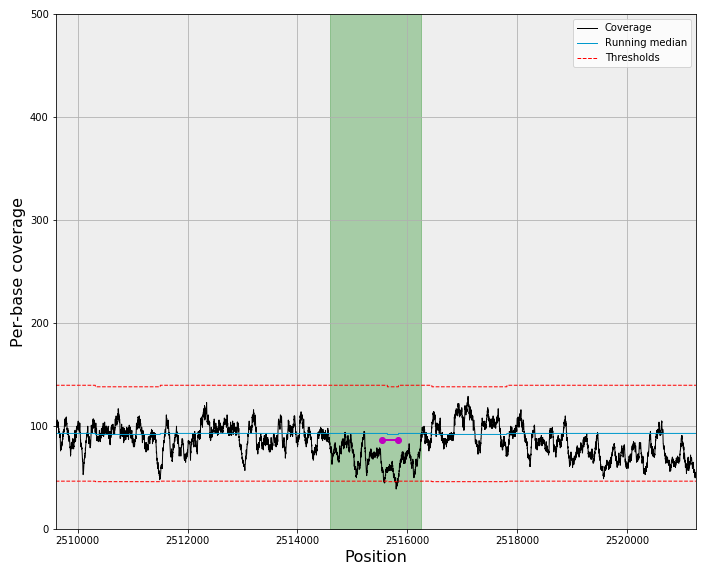

In [42]:
from IPython.display import Image
Image("cnvnator_bin20_16.png")

Il we select the events with size greater than 100, we recover the same events as those reported by cnvnator

In [56]:
roi4.query("size>100")

,Unnamed: 0,chr,start,end,size,mean_cov,max_cov,mean_rm,mean_zscore,max_zscore,log2_ratio
0,0,ENA|FN433596|FN433596.1,58630,59042,412,177.191748,245,102.533981,4.533956,8.739799,0.789209
1,1,ENA|FN433596|FN433596.1,59171,59276,105,264.895238,339,103.000000,9.800631,14.294510,1.362778
2,2,ENA|FN433596|FN433596.1,60173,63217,3044,235.439553,329,104.369580,7.833876,13.496248,1.173655
5,5,ENA|FN433596|FN433596.1,64299,64506,207,174.449275,190,105.000000,4.114280,5.039348,0.732418
6,6,ENA|FN433596|FN433596.1,65652,66458,806,240.263027,415,104.364764,8.122186,18.661335,1.202980
12,12,ENA|FN433596|FN433596.1,66512,67001,489,291.329243,416,104.000000,11.233775,18.721394,1.486067
14,14,ENA|FN433596|FN433596.1,67016,67134,118,294.101695,416,104.000000,11.400286,18.721394,1.499732
17,17,ENA|FN433596|FN433596.1,68394,68800,406,188.076355,242,105.832512,4.837145,7.996870,0.829536
19,19,ENA|FN433596|FN433596.1,73479,74049,570,200.638596,306,105.919298,5.567877,11.768131,0.921634
23,23,ENA|FN433596|FN433596.1,87233,87350,117,226.478632,272,102.000000,7.605611,10.393192,1.150806


# CNOGpro results

In [57]:
cnogpro = pd.read_csv('ST1.csv')
sequana = pd.read_csv("roi_ERR043371.csv")

In [58]:
# Select events 
cnogpro_events = cnogpro.query("CN_HMM!='1'")
cnogpro_events = cnogpro_events[['Left', 'Right']].values

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


WARNING [sequana]:  
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=1.002303845516262, m1=0.9333649392624459, sigma0=0.16582037713350806, sigma1=0.332267589703691
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=1.002303845516262, m1=0.9333649392624459, sigma0=0.16582037713350806, sigma1=0.332267589703691


33
34
35
36
37
38
39
40
41
42


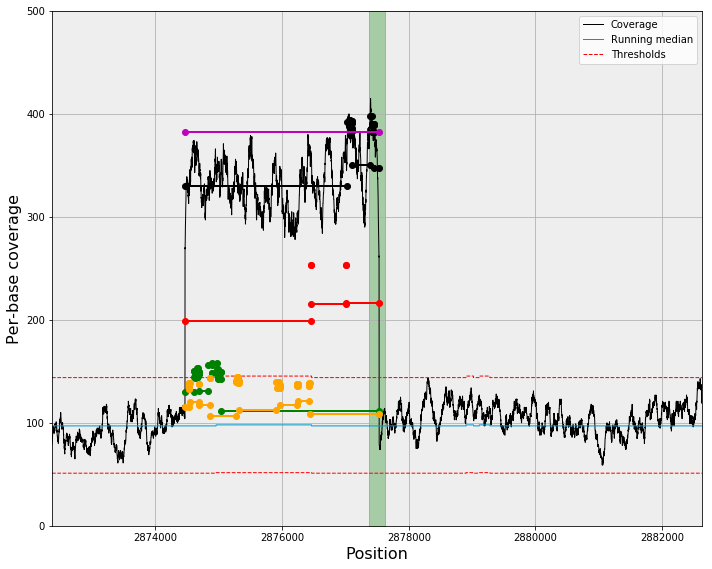

In [59]:
for i, event in enumerate(cnogpro_events):
    plot_event(*event)
    savefig("cnogpro_{}.png".format(i+1))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


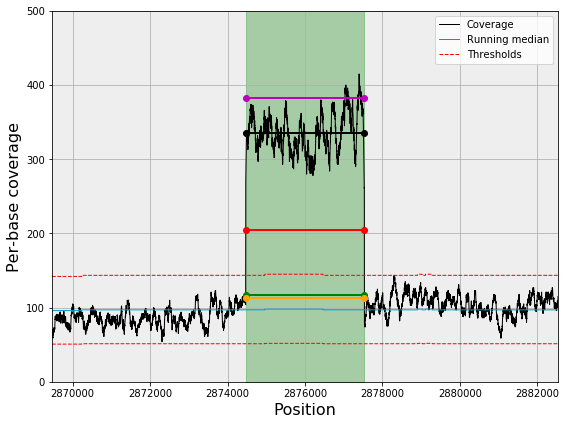

In [317]:
sequana_events = roi4.query('mean_zscore>4.5 or size>60')[['start', 'end']].values

for i, event in enumerate(sequana_events):
    plot_event(*event)
    savefig("sequana_{}.png".format(i+1))
    print(i)

In [315]:
len(roi4.query('mean_zscore>4.5 or size>60'))


30

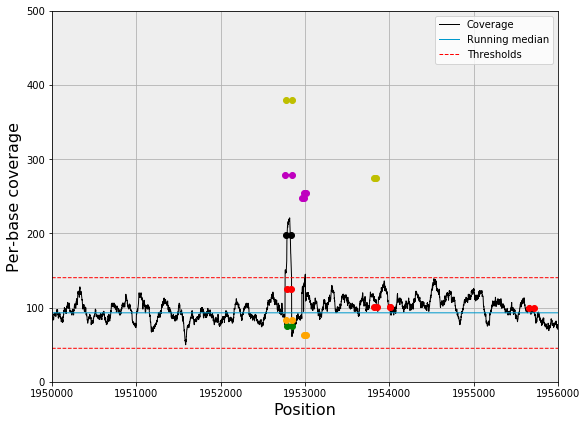

In [300]:
# Event missed by CNOGpro and CNVnator but found by sequana_coverage
plot_rois(1950000, 1956000)

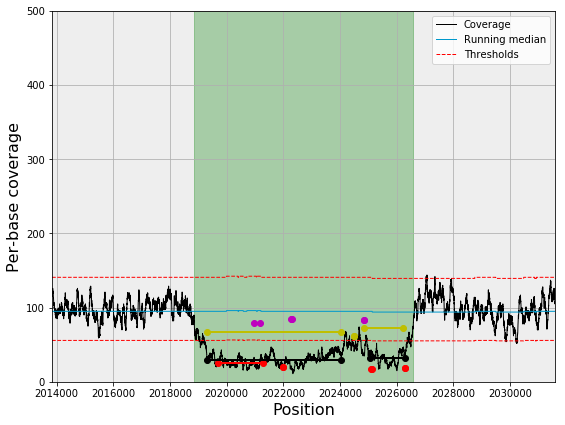

In [302]:
# an event detected by sequana in two parts whereas CNVnator classify this event as a single region
# CNOGpro misses this event and another similar at postion 626000
plot_event(2018841,2026580)

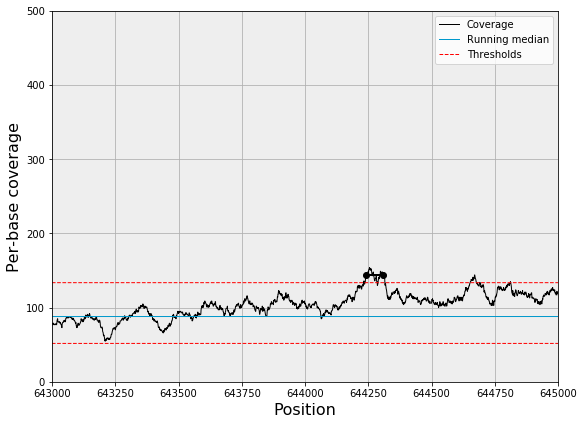

In [321]:
# Sequana false detection example (all false detection have a zscore close to threshold and short length)
plot_rois(643000, 645000)
# here, the running median window size is too large so, the running median does not 
# follow the trend of the data correctly

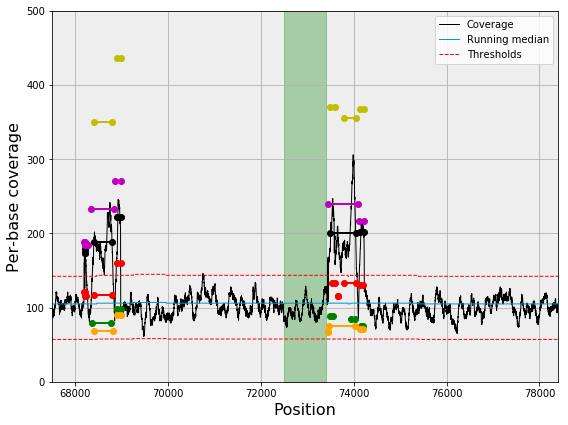

In [324]:
# CNOGpro has false detection next to other events, e.g. 
plot_event(72500, 73400)

WARNING [sequana]:  Warning: k=2 but note that |mu0-mu1| < sigma0. k=1 could be a better choice


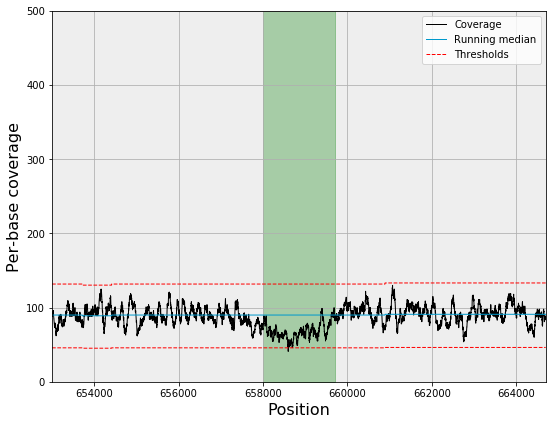

In [326]:
# a false detcetion in CNVnator (3 such events)
plot_event(658000, 659700)

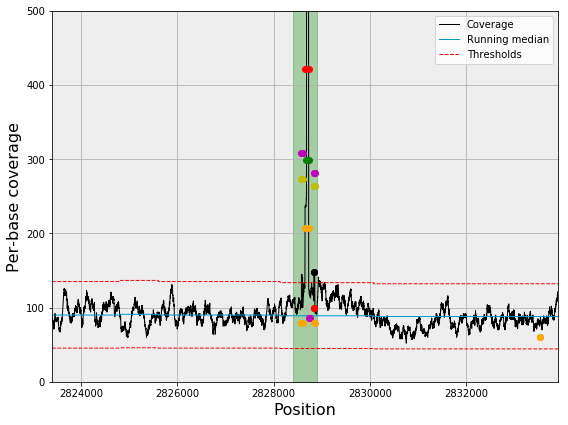

In [334]:
# detected by CNOrpro with bad precision. Missed by cnvnator
plot_event(2828400, 2828900)

# Conclusions

We have shown here that sequana_coverage, CNOGpro and CNVnator can detect CNVs from a bacterial genome.

For the comparison, we use the ERR043379 strain but sequana_coverage ran on the 6 strains give us a control (detection in all strain indicates a real event somehow).

The **computational time** of CNOGpro is not known because we took the results from the paper. As for sequana_coverage, it takse less than a minute. For CNVnator, it depends on the bin parameter but oscillates from 1 to 10 minutes.

**CNV detections:**
- CNOGpro file contains 5466 but we filter the events to keep those with CN_HMM != 1 leading to 43 events.
- CNVnator using a bin of 20 gives 17 events
- sequana_coverage with W=40000 gives about 100 events per strain

**Observations**
- Accuracy
  - CNVnator seems to be the best in the sense of accuracy of location, length of the events and number of events detected. 
  - CNOGpro decomposes events (e.G. event at position ~ 62000) or will 
    has detectd length quite different from the real value (twice as much at position 2,874,000)
  - sequana_coverage has a behaviour in between CNVnator and CNOgpro).
    true CNV (CN=2) are well dectected like CNVnator
  
- Missed events
  - CNVnator may miss short yet strong events (not CNV). 
  - CNOGPro may miss short yet strong events (not CNV) see e.g. position 
    1,952,000
- False detections:
  - CNVnator detect events e.g. pos 1,956,000 that are not 
  - CNOGpro detect events e.g. pos 1,956,000 that are not 
  - sequana_coverage has more short false dectection but a simple filter can be used (e.g. size < 60 or |zscore| < 4.5) to select about 30 events